# Cell map of the zebrafish embryo using graph abstraction

This notebook reproduces the main cell map with its lineage relations, starting from the results of [Wagner *et al.*, Science (2018)](10.1126/science.aar4362).

See this [website](https://kleintools.hms.harvard.edu/paper_websites/wagner_zebrafish_timecourse2018/mainpage.html) for an interactive exploration. The data has been obtained from the original authors by email.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
from scipy.sparse import csr_matrix
import scanpy.api as sc

sc.set_figure_params(dpi=200, color_map='viridis')  # low dpi (dots per inch) yields small inline figures
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/zebrafish.h5ad'

scanpy==1.2.0 anndata==0.6.4+6.gd9727ca numpy==1.13.1 scipy==1.0.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
var = pd.read_csv('./data/gene_names.txt', index_col=0, header=None)

In [3]:
cluster_indices = np.genfromtxt('./data/cell_cluster_indexes.txt', dtype=int)
clusters = pd.Categorical(cluster_indices)
clusters.categories = ['?'] + np.genfromtxt('./data/cluster_names.txt', dtype=str, delimiter=',').tolist()
obs = pd.DataFrame({'clusters': clusters})

The graph.

In [4]:
cell_cell_edges = np.genfromtxt('./data/cell_cell_edges.csv', dtype=int, delimiter=',')
cell_cell_edges -= 1  # our indexing starts with 0 as common in Python, C etc.
from scipy.sparse import coo_matrix
rows = cell_cell_edges[:, 0]
cols = cell_cell_edges[:, 1]
length = len(obs)
ones = np.ones(len(rows), np.uint32)
connectivities = coo_matrix((ones, (rows, cols)), shape=(length, length))
# make sure it's symmsetric
connectivities = connectivities + connectivities.T

Let's just add it as unstructured annotation as if it would have been computed through `pp.neighbors`.

In [5]:
uns = {'neighbors': {'connectivities': connectivities.tocsr()}}

Create the AnnData object.

In [6]:
adata = sc.AnnData(obs=obs, var=var, uns=uns)
# remove the outliers
adata = adata[adata.obs['clusters'] != '?']

In [7]:
adata

View of AnnData object with n_obs × n_vars = 53181 × 30677 
    obs: 'clusters'
    uns: 'neighbors'

In [8]:
adata.write(results_file)

## Roughly embedding the graph

In [9]:
adata = sc.read(results_file)

In [10]:
sc.tl.umap(adata)

computing UMAP
    finished (0:02:12.25) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [11]:
sc.tl.draw_graph(adata, maxiter=100)

drawing single-cell graph using layout "fa"


/Users/alexwolf/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


    finished (0:02:55.90) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


In [12]:
adata.write(results_file)

## Create different coarse-grained clusterings

In [6]:
adata = sc.read(results_file)

In [8]:
cats = adata.obs['clusters'].cat.categories

Cluster coarse cell types.

In [9]:
clusters_coarse = np.unique(['-'.join(c.split('-')[1:]).split(' - ')[0] for c in cats])

These are still a lot of clusters - too many for an overview map.

In [10]:
clusters_coarse

array(['EVL', 'anterior neural ridge', 'apoptotic-like',
       'apoptotic-like 2', 'differentiating neurons',
       'dorsal involuted anterior', 'dorsal margin',
       'dorsal margin involuted', 'ectoderm', 'endoderm', 'endothelial',
       'epidermal', 'epidermal anterior', 'epiphysis', 'erythroid',
       'forerunner cells', 'germline', 'hatching gland', 'heart',
       'heart field', 'heart mature', 'ionocyte', 'lateral line',
       'lateral line primordium', 'lens', 'lens placode', 'leukocyte',
       'macrophage', 'mesoderm', 'mesoderm lateral plate', 'muscle',
       'myotome', 'nanog-high', 'neural', 'neural crest', 'neural plate',
       'non-dorsal involuted anterior', 'non-dorsal margin',
       'non-dorsal margin involuted', 'notocord', 'optic cup',
       'optic primordium', 'otic placode', 'pancreas primordium',
       'pectoral fin bud', 'pectoral fin field', 'periderm',
       'pharyngeal arch', 'pharyngeal pouch', 'pluripotent',
       'prechordal plate', 'proctodeu

Let us reduce this manually.

In [11]:
clusters_coarse = [
       'EVL', 'apoptotic-like', 'differentiating neurons',
       'dorsal', 'ectoderm', 'endoderm', 'endothelial',
       'epidermal', 'epiphysis', 'erythroid',
       'forerunner cells', 'germline', 'hatching gland', 'heart',
       'ionocyte', 'lateral line',
       'lens', 'leukocyte',
       'macrophage', 'mesoderm', 'muscle',
       'myotome', 'nanog-high', 'neural', 'neural crest',
       'non-dorsal', 'notocord', 'optic',
       'optic', 'otic', 'pancreas primordium',
       'pectoral', 'pectoral', 'periderm',
       'pharyngeal', 'pharyngeal', 'pluripotent',
       'prechordal plate', 'proctodeum', 'pronephric duct',
       'retina', 'tailbud']

Create an annotation that labels cells based on these key words by finding them in the very fine-grained reference clustering.

In [12]:
d = {}
for c in adata.obs['clusters'].cat.categories:
    len_match = 0
    for cc in clusters_coarse:
        if cc in c and len(cc) > len_match:  # make sure we find the best match
            d[c] = cc  # we should not break if we find something
            len_match = len(cc)

In [13]:
sc.utils.merge_groups(adata, 'clusters', key_added='clusters_coarse', map_groups=d)

In [14]:
adata

AnnData object with n_obs × n_vars = 53181 × 30677 
    obs: 'clusters', 'clusters_coarse'
    uns: 'neighbors'

Keep the time point information.

In [15]:
clusters_coarse_time = np.unique([c.split(' - ')[0] for c in cats])

In [16]:
d = {}
for c in adata.obs['clusters'].cat.categories:
    len_match = 0
    for cc in clusters_coarse_time:
        if cc in c and len(cc) > len_match:  # make sure we find the best match
            d[c] = cc  # we should not break if we find something
            len_match = len(cc)

In [17]:
sc.utils.merge_groups(adata, 'clusters', key_added='clusters_coarse_time', map_groups=d)

Cluster by time point.

In [18]:
clusters_time = np.array([c.split('-')[0][:2] for c in cats])

In [19]:
d = {}
clusters_time_unique = np.unique(clusters_time)
for c in adata.obs['clusters'].cat.categories:
    for cc in clusters_time_unique:
        if c.startswith(cc):
            d[c] = cc
            break

In [20]:
sc.utils.merge_groups(adata, 'clusters', key_added='clusters_time', map_groups=d)

In [21]:
adata.obs['time'] = adata.obs['clusters_time'].astype(int)

Visualize the clusters.

saving figure to file ./figures/umap.pdf


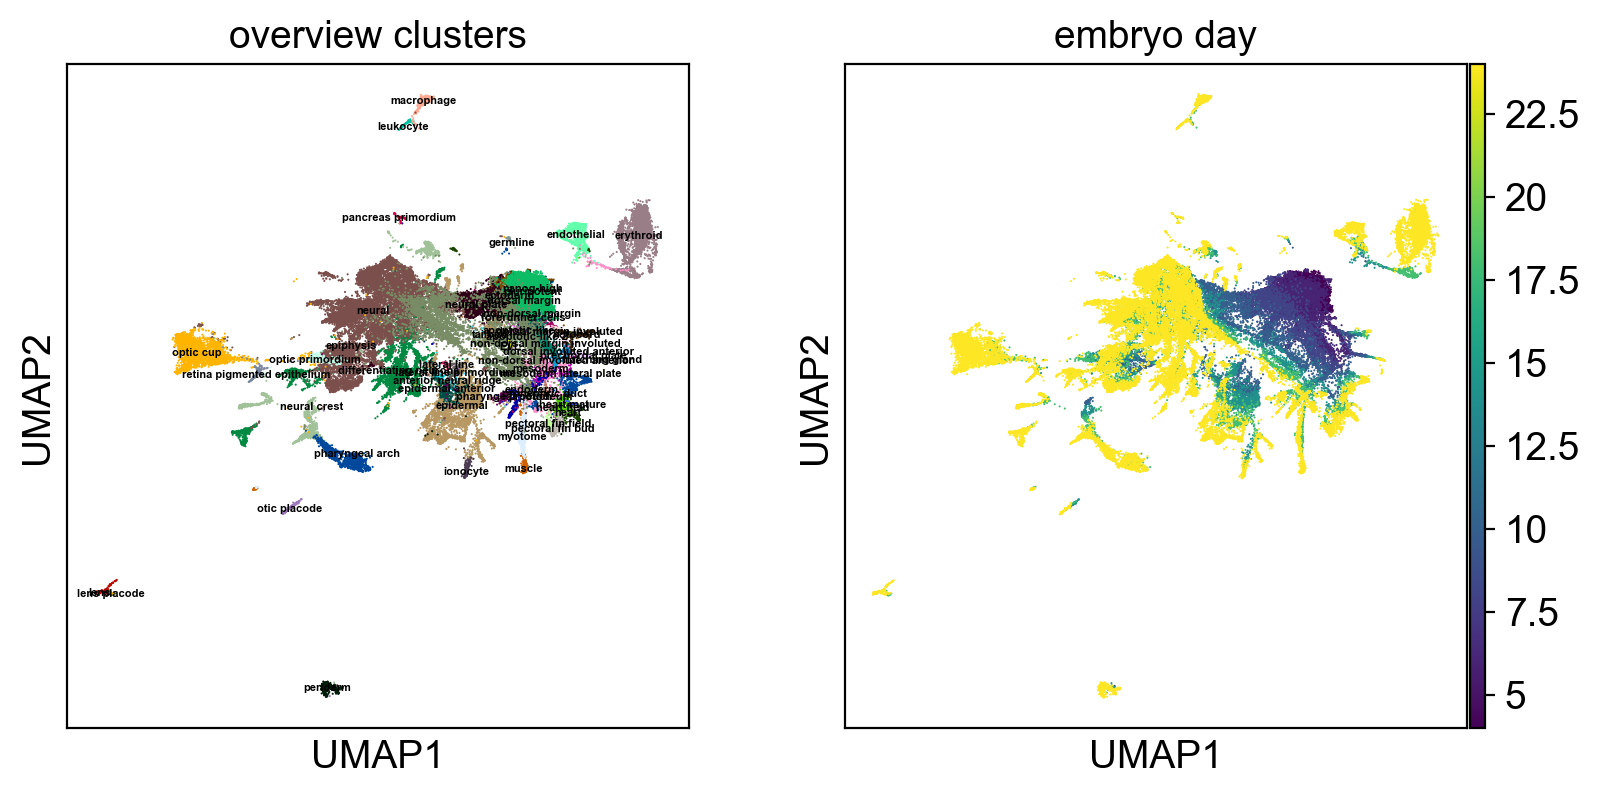

In [26]:
sc.pl.umap(adata, color=['clusters_coarse', 'time'], legend_loc='on data', legend_fontsize=4)

saving figure to file ./figures/draw_graph_fa.pdf


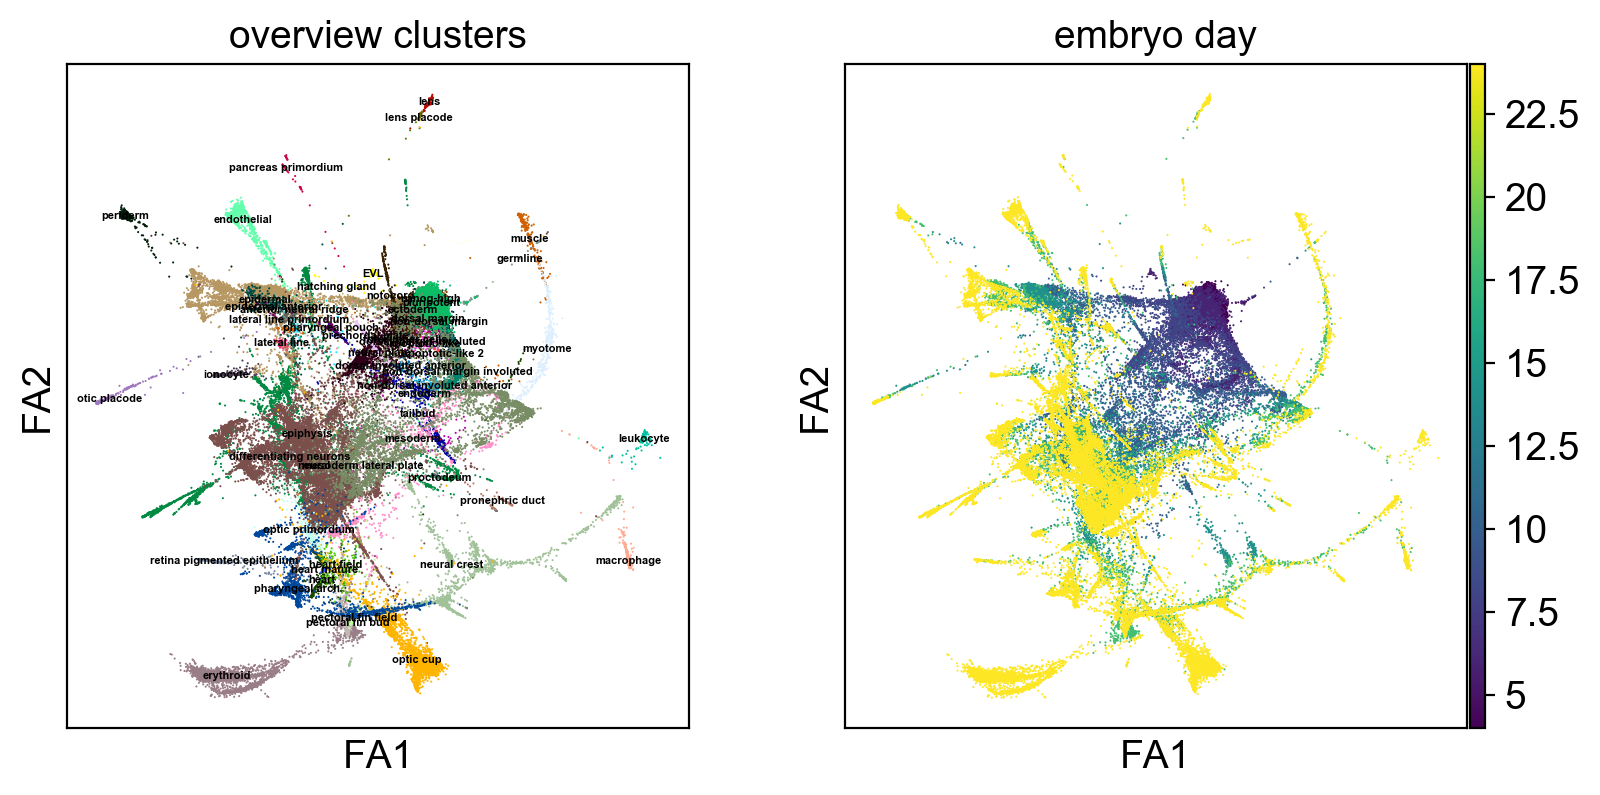

In [27]:
sc.pl.draw_graph(adata, color=['clusters_coarse', 'time'], legend_loc='on data', legend_fontsize=4)

Quite evidently, both of the previous embeddings are "messy" and do not reflect the topology well.

In [28]:
adata.write(results_file)

## PAGA for time points

Let's see whether we get the expected topology among time points using PAGA.

In [9]:
adata = sc.read(results_file)

Indeed, we do.

In [37]:
sc.tl.paga(adata, groups='clusters_time', model='v1.0')

running partition-based graph abstraction (PAGA)
    finished (0:00:01.49) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./figures/paga_time.pdf


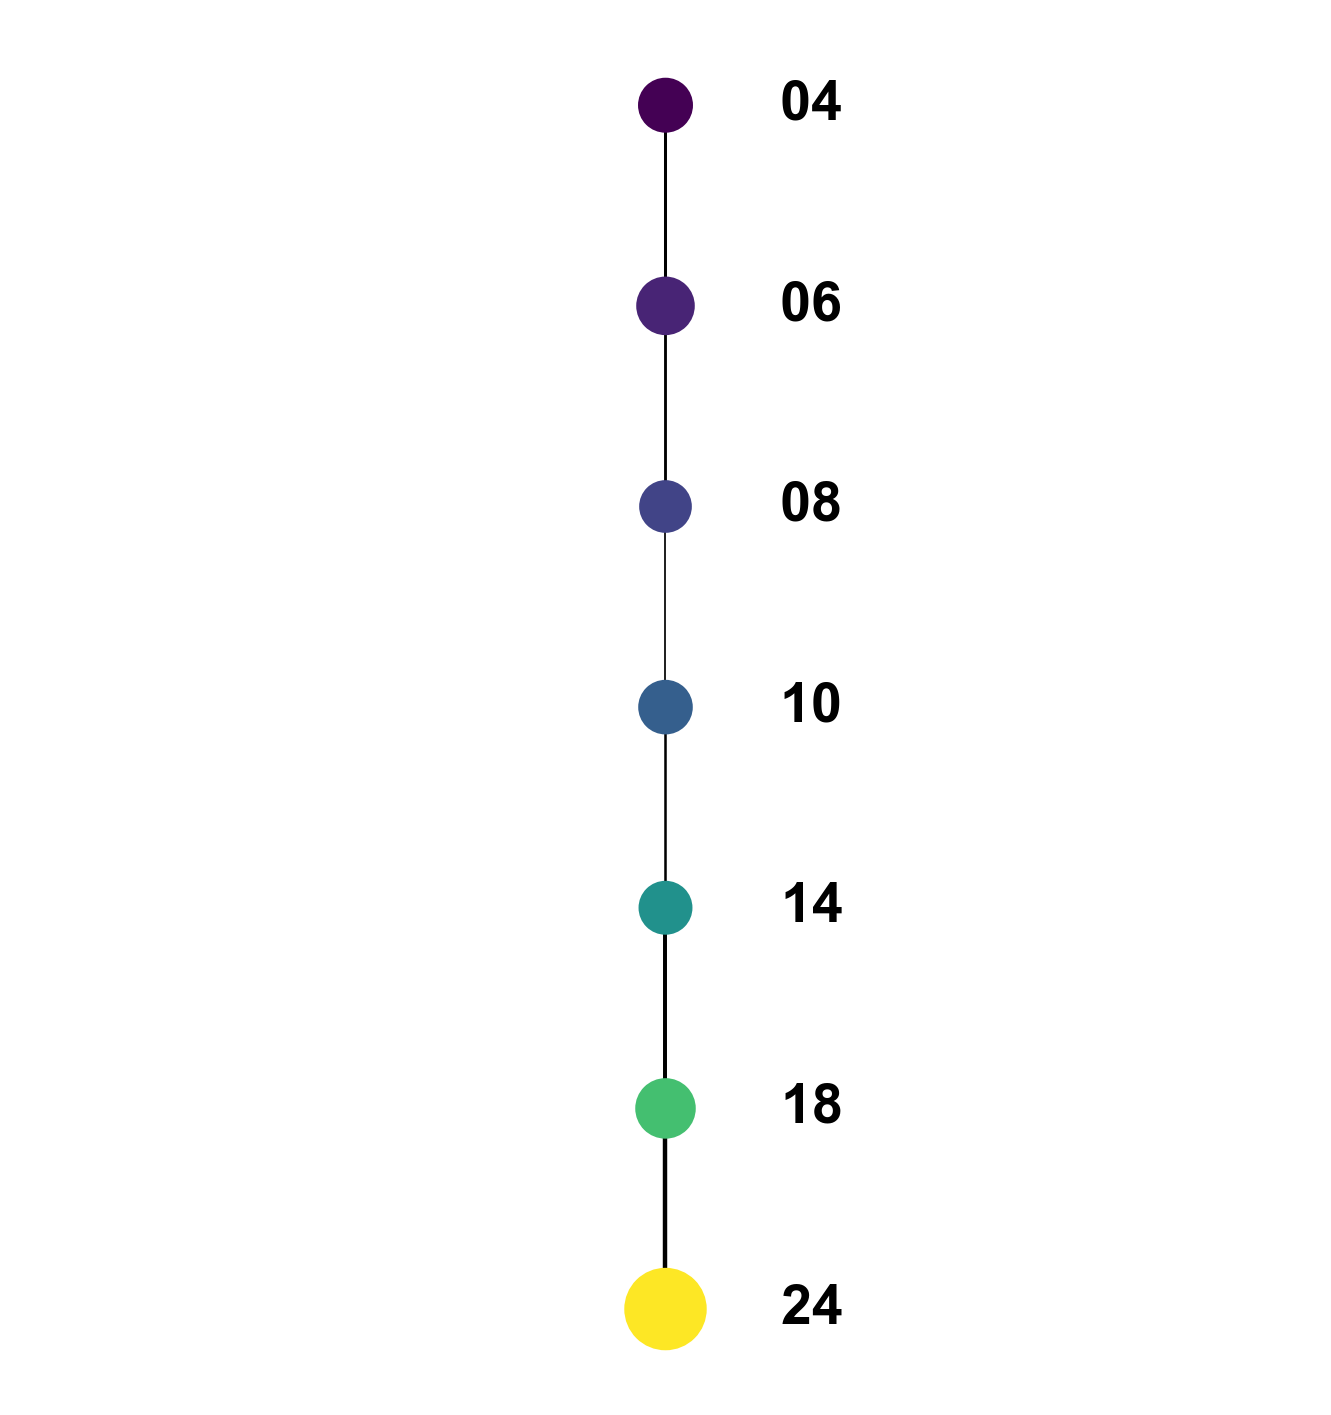

In [38]:
sc.pl.paga(adata,
           labels=['                   ' + t for t in adata.obs['clusters_time'].cat.categories],
           colors=adata.obs['clusters_time'].cat.categories.astype(int),
           fontsize=10, layout='rt', frameon=False, colorbar=False, node_size_scale=0.5,
           edge_width_scale=0.15, save='_time')

## PAGA for overview clusters

In [31]:
sc.tl.paga(adata, groups='clusters_coarse', model='v1.0')

running partition-based graph abstraction (PAGA)
    finished (0:00:01.74) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


--> added 'pos', the PAGA positions (adata.uns['paga'])


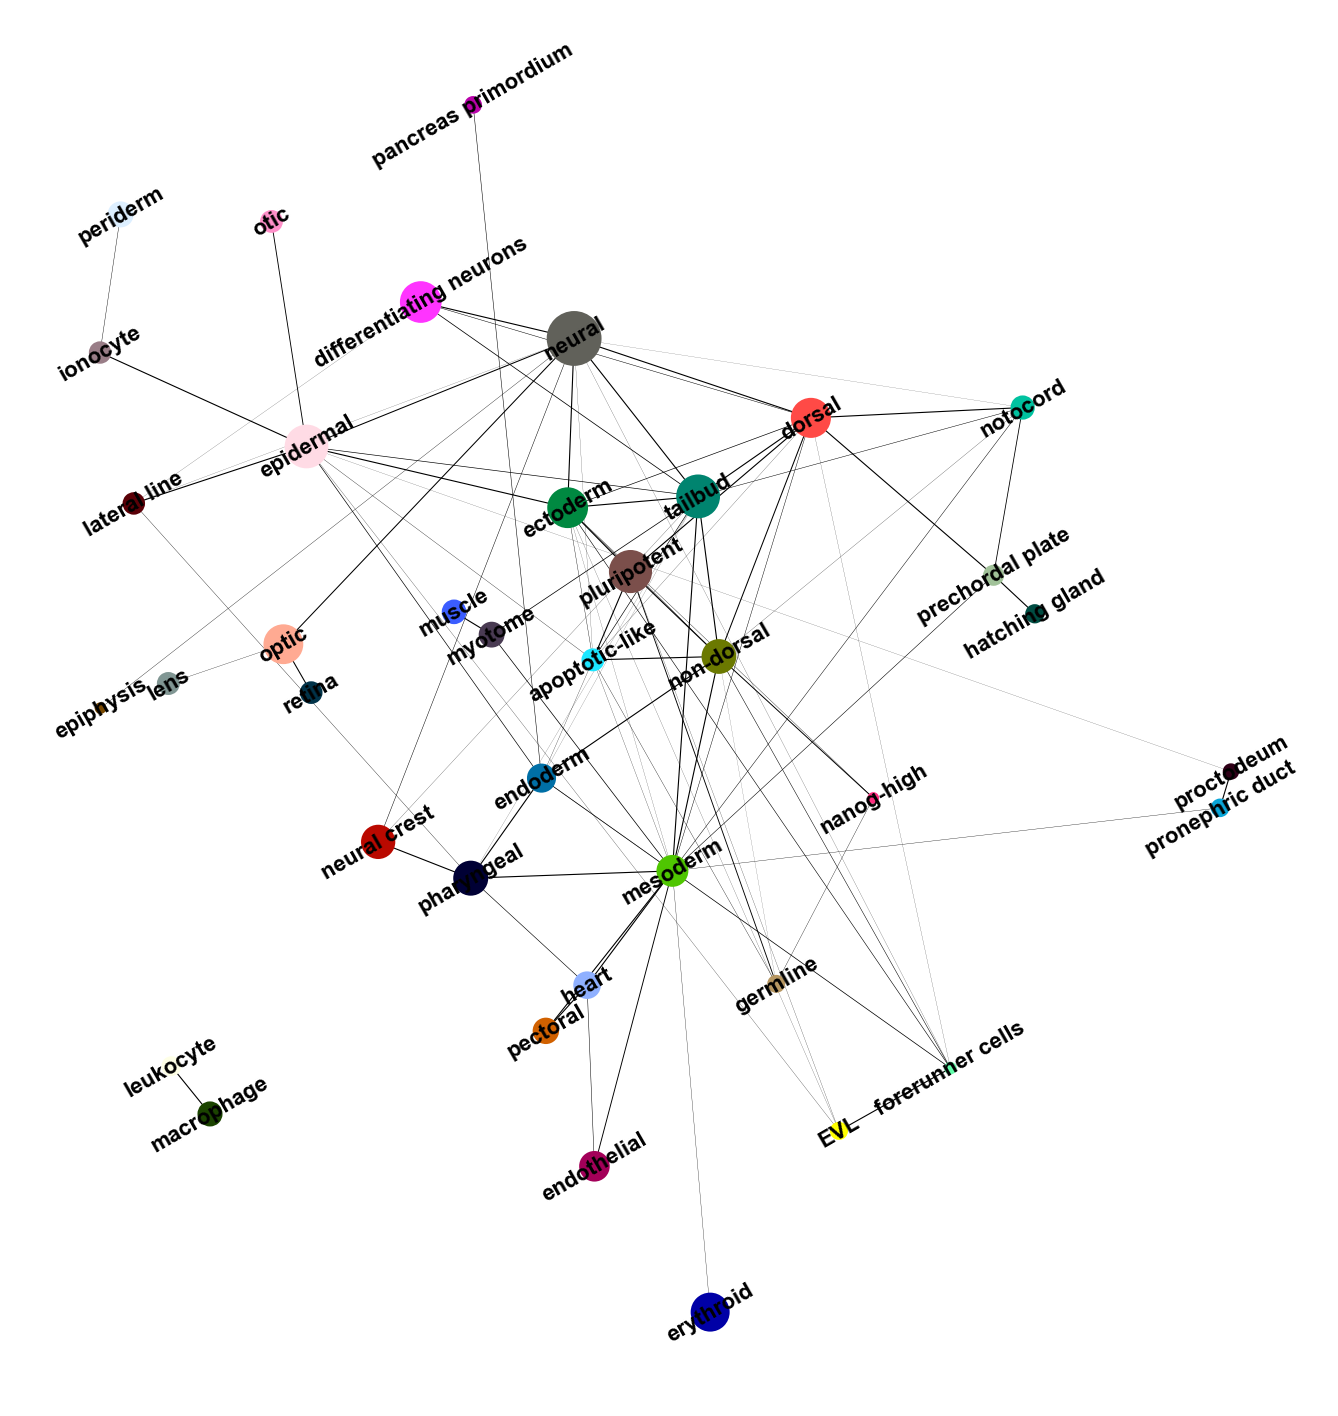

In [32]:
sc.pl.paga(adata, threshold=0.003, layout='fa', frameon=False, fontsize=4, node_size_scale=0.1,
           max_edge_width=0.2, text_kwds={'rotation': 30}, colorbar=False)

## Computing a topologically faithful single-cell embedding

We can now use the abstrated graph to initialize graph drawing and obtain embeddings that much better reflect the topology than if we had started with random initialization, as above.

In [42]:
sc.tl.draw_graph(adata, init_pos='paga', maxiter=100)
np.save('./write/X_draw_graph_fa_paga.npy', adata.obsm['X_draw_graph_fa'])

In [56]:
adata.obsm['X_draw_graph_fa'] = np.load('./write/X_draw_graph_fa_paga.npy')
adata.uns['draw_graph'] = {'params': {'layout': 'fa'}}

In [57]:
sc.set_figure_params(dpi=200, dpi_save=200, color_map='viridis')

In [58]:
adata_subset = adata[~adata.obs['clusters_coarse'].isin(['nanog-high', 'forerunner cells'])]

Reorder the categories so that tailbud is below the other.

In [281]:
adata_subset.obs['clusters_coarse'].cat.reorder_categories(['tailbud', 'EVL', 'apoptotic-like', 'differentiating neurons', 'dorsal',
       'ectoderm', 'endoderm', 'endothelial', 'epidermal', 'epiphysis',
       'erythroid', 'germline', 'hatching gland', 'heart', 'ionocyte',
       'lateral line', 'lens', 'leukocyte', 'macrophage', 'mesoderm', 'muscle',
       'myotome', 'neural', 'neural crest', 'non-dorsal', 'notocord', 'optic',
       'otic', 'pancreas primordium', 'pectoral', 'periderm', 'pharyngeal',
       'pluripotent', 'prechordal plate', 'proctodeum', 'pronephric duct',
       'retina'], inplace=True)

Rename categories so that 'notocord' gets an '\n' infront.

In [297]:
adata_subset.rename_categories('clusters_coarse', ['tailbud', 'EVL', 'apoptotic-like', 'differentiating neurons', 'dorsal',
       'ectoderm', 'endoderm', 'endothelial', 'epidermal', 'epiphysis',
       'erythroid', 'germline', 'hatching gland', 'heart', 'ionocyte',
       'lateral line', 'lens', 'leukocyte', 'macrophage', 'mesoderm', 'muscle',
       'myotome', 'neural', 'neural crest', 'non-dorsal', '\nnotocord', 'optic',
       'otic', 'pancreas primordium', 'pectoral', 'periderm', 'pharyngeal',
       'pluripotent', 'prechordal plate\n', 'proctodeum', 'pronephric duct',
       'retina'])

exporting label positions to ./write/pos.csv


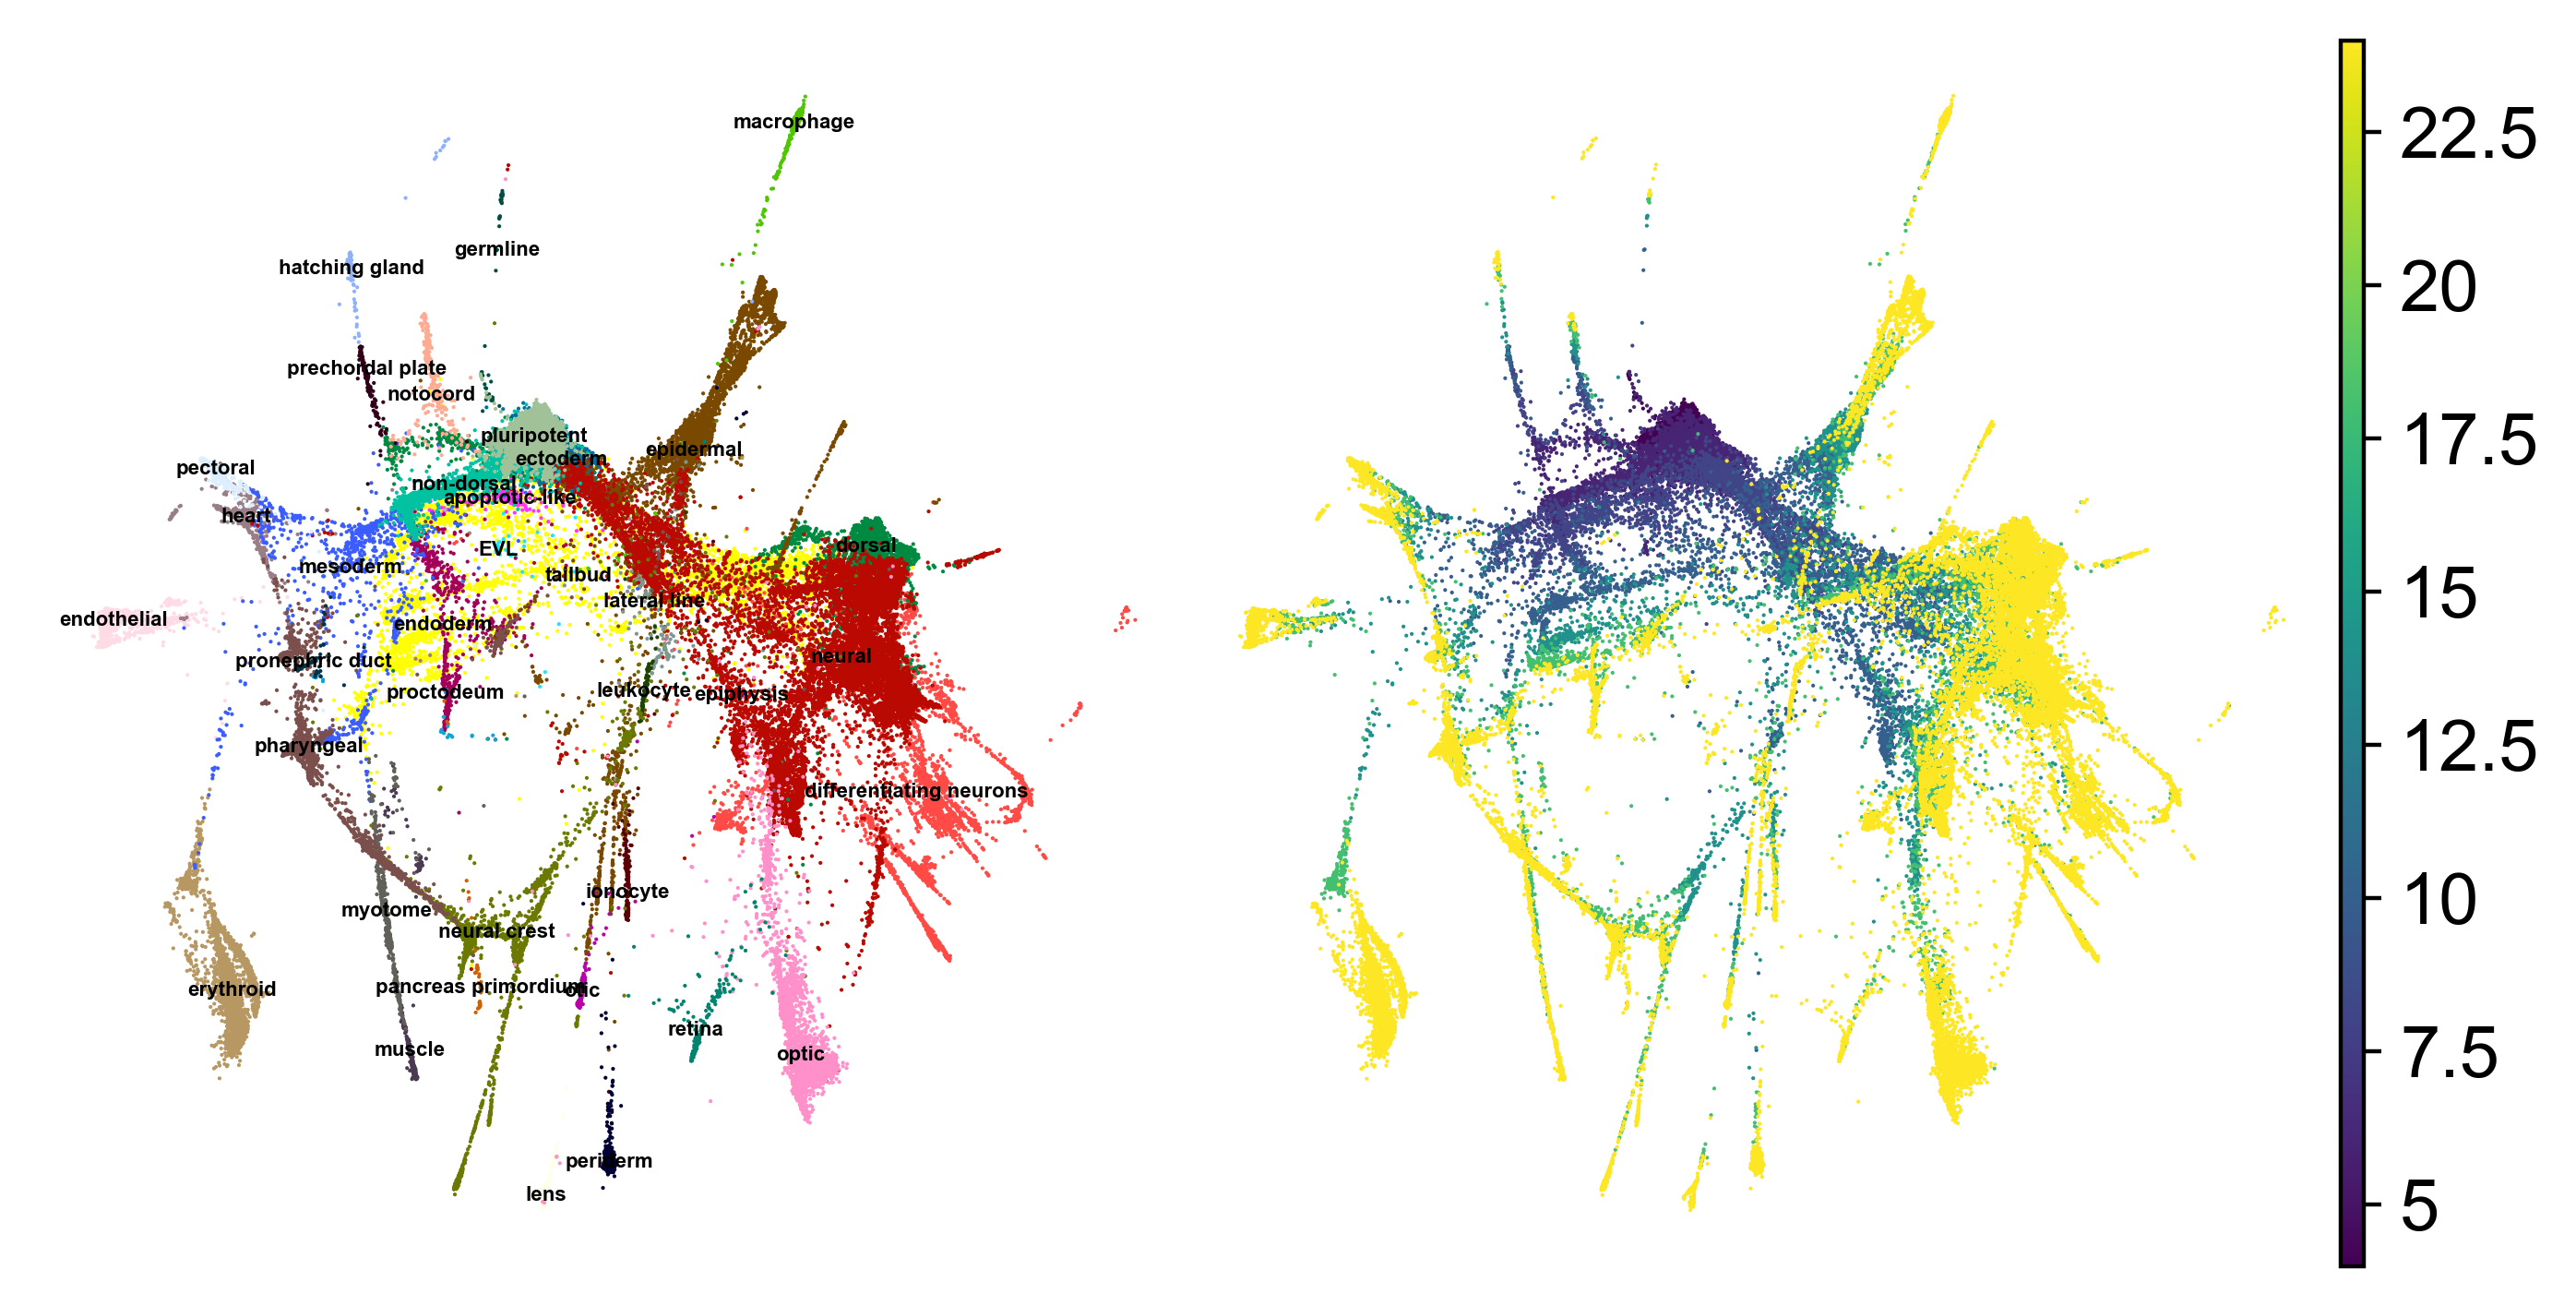

In [298]:
axs = sc.pl.draw_graph(
    adata_subset,
    color=['clusters_coarse', 'time'],
    right_margin=0, legend_loc='on data export', legend_fontsize=4, save=False, show=False)
for ax in axs:
    ax.set_frame_on(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
pl.savefig('./figures/draw_graph_fa_paga.pdf', bbox_inches='tight')
pl.show()

In [300]:
pos = np.loadtxt('./write/pos.csv', delimiter=',')

Graph has more than a single connected component. To restrict to this component, pass `single_component=True`.
--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./figures/paga_overview.pdf


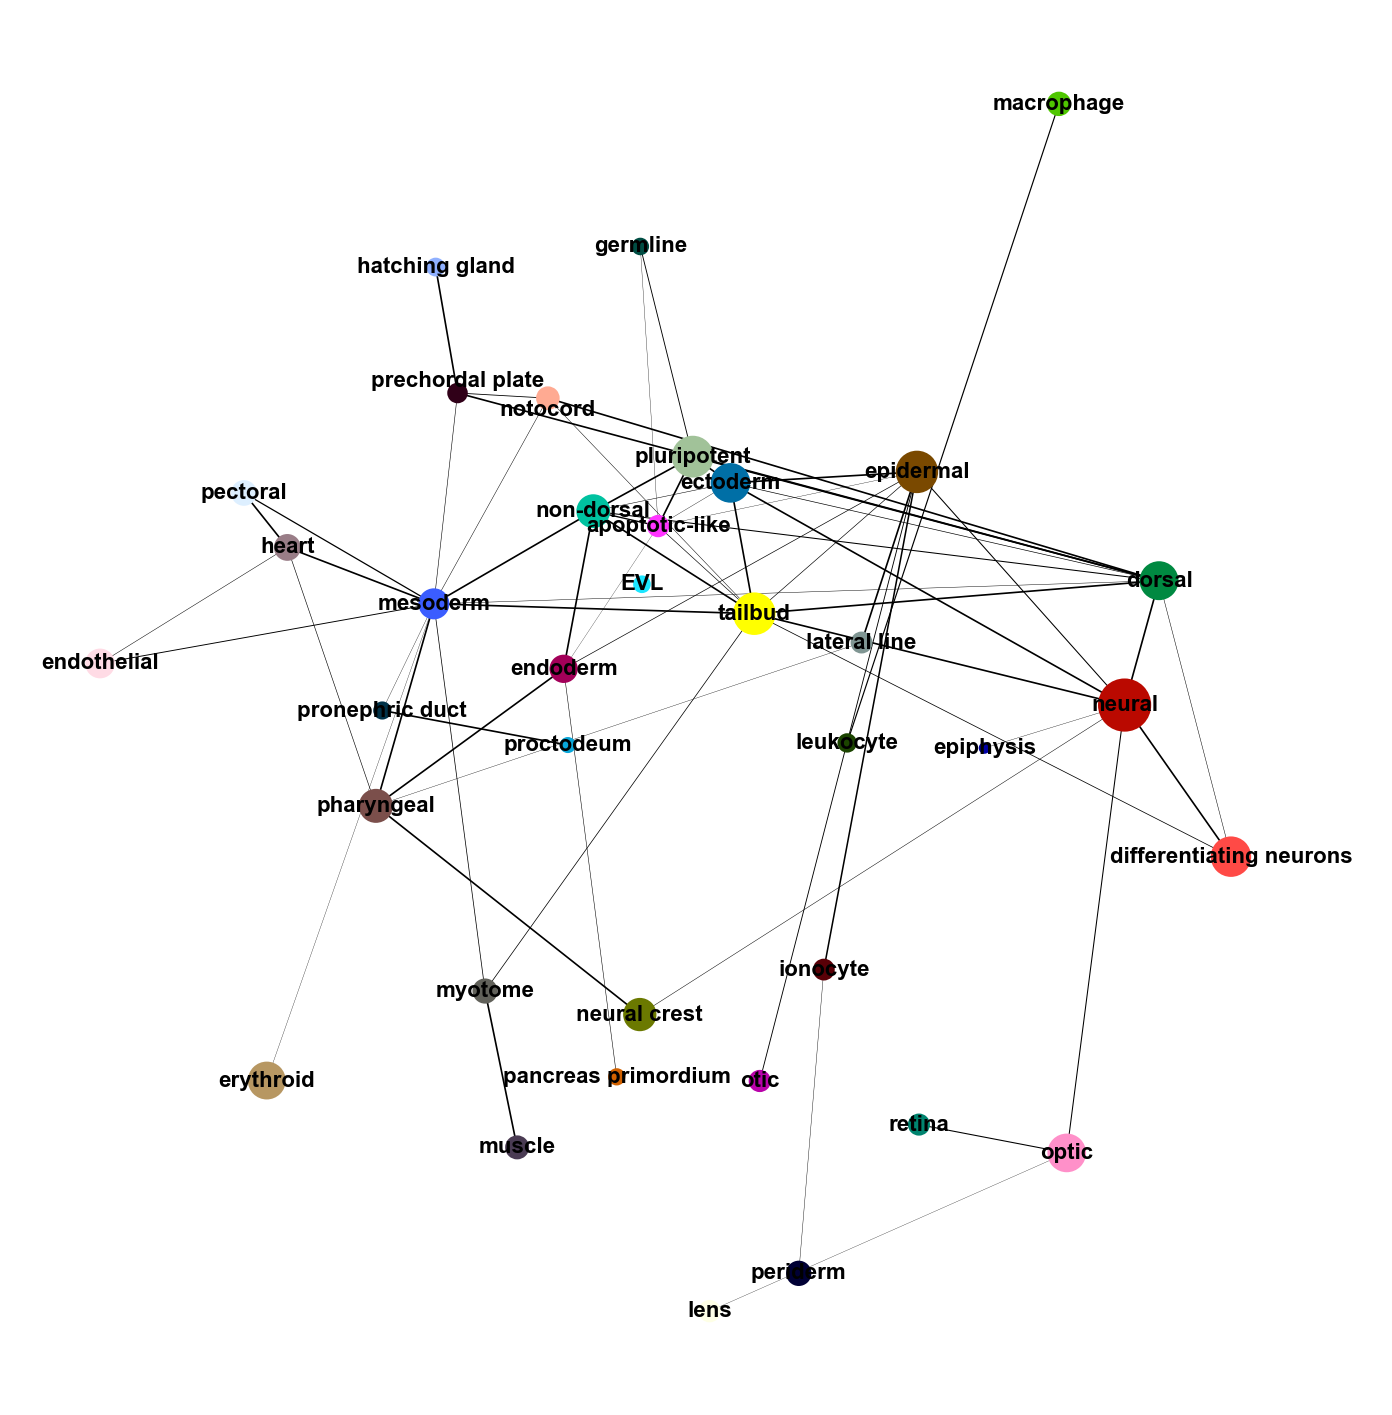

In [301]:
sc.pl.paga(adata_subset, pos=pos, frameon=False,
           threshold=0.006,
           fontsize=4, node_size_scale=0.1, text_kwds={'fontweight': 'bold'},
           max_edge_width=0.3, colorbar=False,
           save='_overview')

exporting label positions to ./write/pos.csv


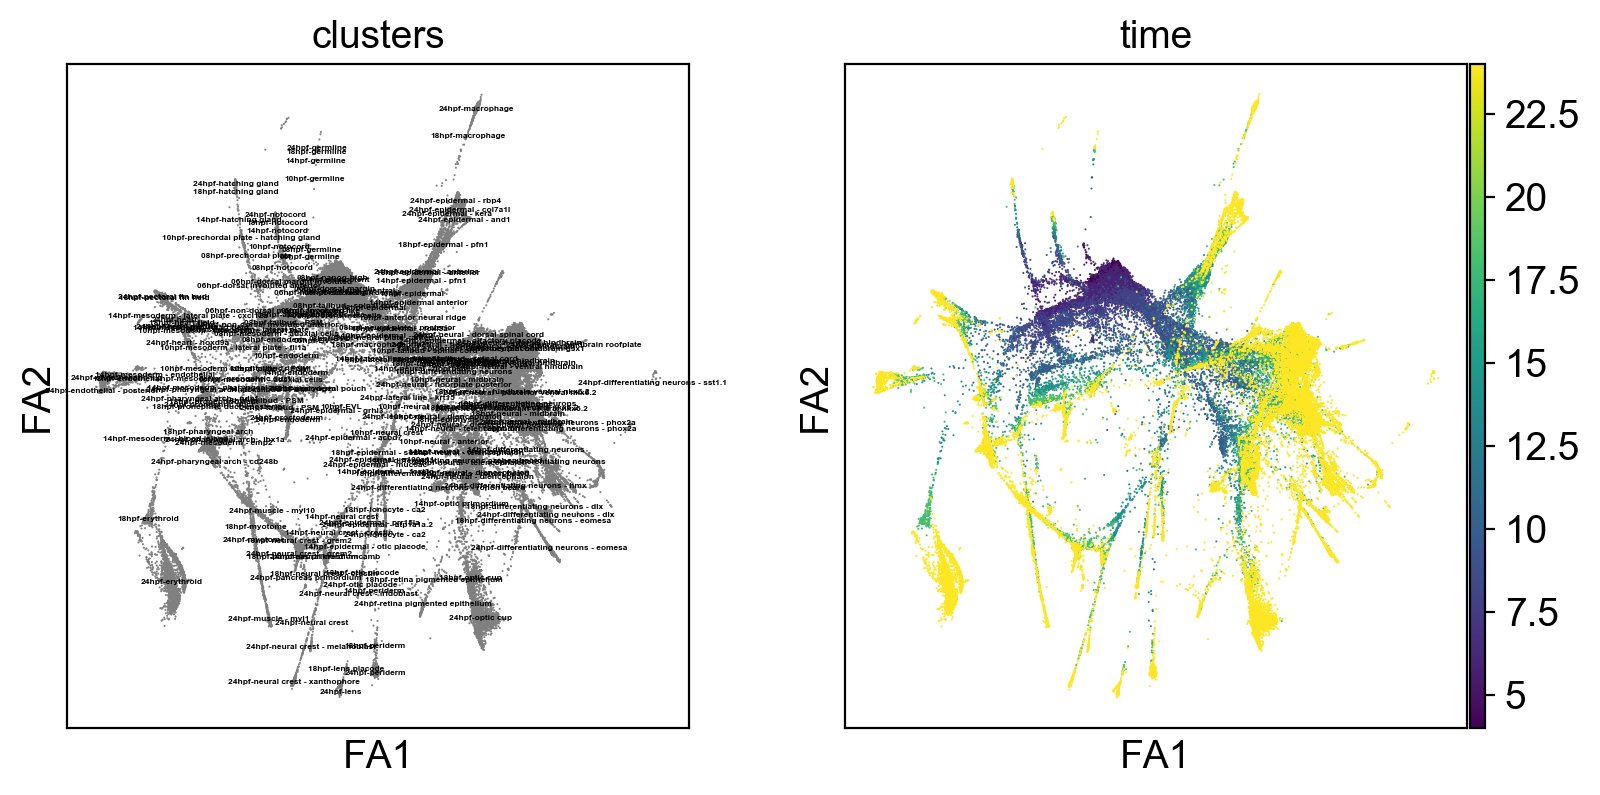

In [82]:
sc.pl.draw_graph(adata, color=['clusters', 'time'], legend_loc='on data export', legend_fontsize=3)

## PAGA for clusters of Wagner et al. (2018)

In [23]:
sc.tl.paga(adata, groups='clusters', model='v1.0')

running partition-based graph abstraction (PAGA)
    finished (0:00:01.80) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


In [24]:
labels = [l[6:] for l in adata.obs['clusters'].cat.categories]

In [25]:
sc.settings.set_figure_params(dpi=200, color_map='viridis')

Let's run a default visualization.

--> added 'pos', the PAGA positions (adata.uns['paga'])


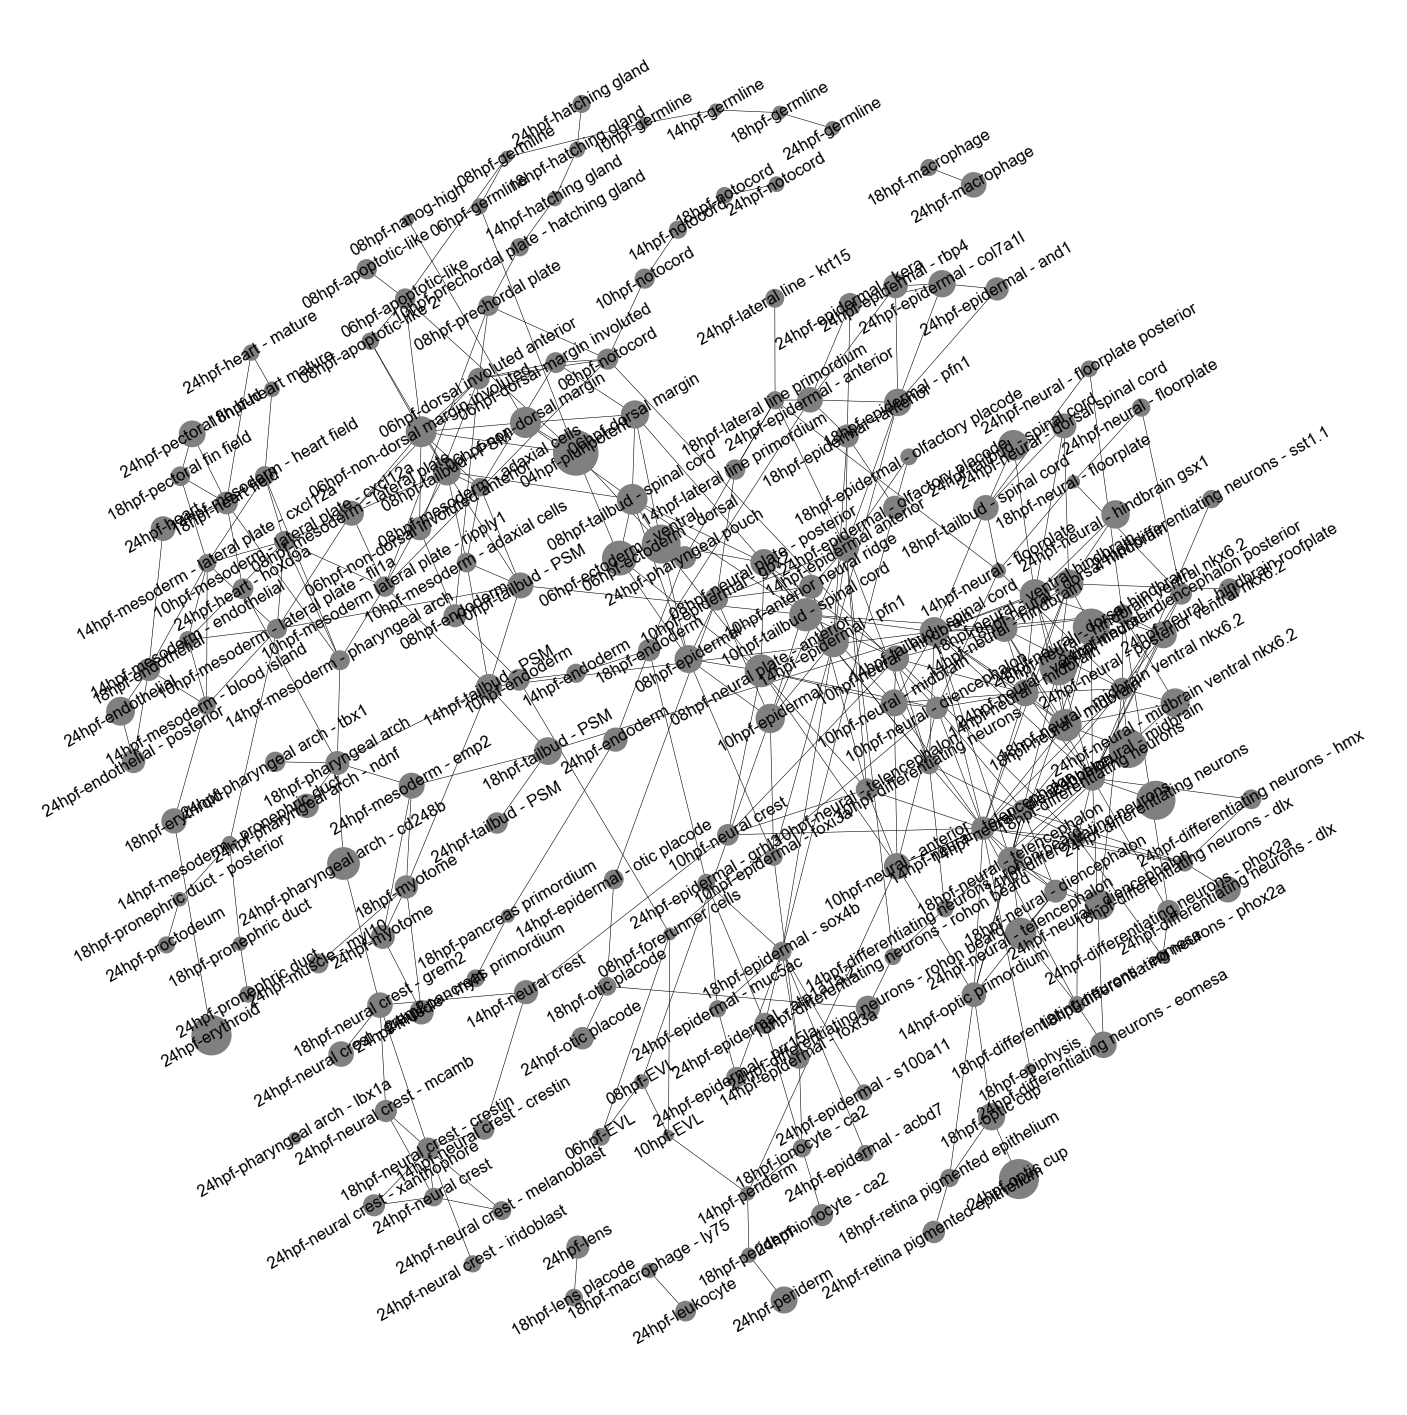

In [26]:
sc.pl.paga(adata, colors='grey',  threshold=0.02, frameon=False, fontweight='normal',
           fontsize=3, text_kwds={'rotation': 30}, node_size_scale=0.1, max_edge_width=0.1)

To assess whether this makes sense, compare it with the result by Wagner et al. (2018).

In [27]:
cluster_cluster_edges = np.genfromtxt('./data/cluster_cluster_edges.csv', dtype=int, delimiter=',')
adata.uns['paga']['wagner18'] = csr_matrix(np.abs(cluster_cluster_edges))

In [28]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve, average_precision_score

In [29]:
wagner18 = adata.uns['paga']['wagner18']
confidence = adata.uns['paga']['connectivities']

In [30]:
precision, recall, thresholds = precision_recall_curve(wagner18.toarray().flatten(), confidence.toarray().flatten())

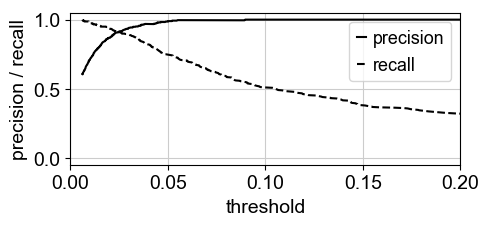

In [31]:
pl.figure(figsize=(5, 2), dpi=50)
pl.plot(thresholds, precision[:-1], '-', c='black', label='precision')
pl.plot(thresholds, recall[:-1], '--', c='black', label='recall')
pl.xlim(0, 0.2)
pl.legend()
pl.xlabel('threshold')
pl.ylabel('precision / recall')
pl.savefig('./figures/metrics_prec_recall_thresholds.pdf', bbox_inches='tight')
pl.show()

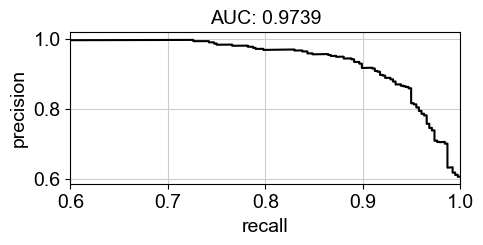

In [32]:
pl.figure(figsize=(5, 2), dpi=50)
pl.plot(recall, precision, c='black')
pl.ylabel('precision')
pl.xlabel('recall')
pl.title('AUC: {:.4f}'.format(auc(recall, precision)))
pl.xlim(0.6, 1.0)
pl.savefig('./figures/metrics_prec_recall.pdf', bbox_inches='tight')
pl.show()

As this is such a sparse problem, false positive rates in the ROC curve are extremely low.

In [33]:
fp, tp, thresholds = roc_curve(wagner18.toarray().flatten(), confidence.toarray().flatten())

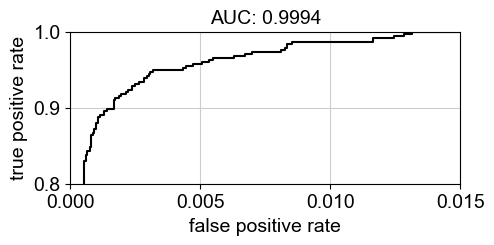

In [36]:
pl.figure(figsize=(5, 2), dpi=50)
pl.plot(fp, tp, c='black')
pl.xlabel('false positive rate')
pl.ylabel('true positive rate')
pl.xlim(0, 0.015)
pl.ylim(0.8, 1.0)
pl.xticks([0, 0.005, 0.01, 0.015])
pl.title('AUC: {:.4f}'.format(auc(fp, tp)))
pl.savefig('./figures/metrics_roc.pdf', bbox_inches='tight')
pl.show()

Choose a meaningful threshold to visually compare predictions with reference.

In [38]:
threshold = 0.025

paga_graph = adata.uns['paga']['connectivities'].copy()
paga_graph.data[paga_graph.data >= threshold] = 1
paga_graph.data[paga_graph.data < threshold] = 0
paga_graph.eliminate_zeros()

false_negatives = wagner18 - paga_graph  # additional edges of wagner18
false_negatives.data[false_negatives.data < 0] = 0
false_negatives.eliminate_zeros()

false_positives = paga_graph - wagner18  # additional edges of PAGA
false_positives.data[false_positives.data < 0] = 0
false_positives.eliminate_zeros()

print('wagner18 edges:', wagner18.nnz)
print('sensitivity (detected edges):', (wagner18.nnz - false_negatives.nnz) / wagner18.nnz)
print('recall (correct detections):',  (paga_graph.nnz - false_positives.nnz) / paga_graph.nnz)

adata.uns['paga']['predicted_edges'] = paga_graph
adata.uns['paga']['false_negatives'] = false_negatives
adata.uns['paga']['false_positives'] = false_positives

wagner18 edges: 752
sensitivity (detected edges): 0.9122340425531915
recall (correct detections): 0.9146666666666666


In [39]:
pos = np.loadtxt('./write/pos.csv', delimiter=',')

In [53]:
labels = ['' for l in labels]

In [54]:
params = dict(labels=labels, color='time', pos=pos, fontweight='normal', frameon=False, fontsize=3, text_kwds={'rotation': 30}, node_size_scale=0.1, max_edge_width=0.5, add_pos=False)

In [55]:
sc.set_figure_params(dpi=100, color_map='viridis')

saving figure to file ./figures/paga_prediction.pdf


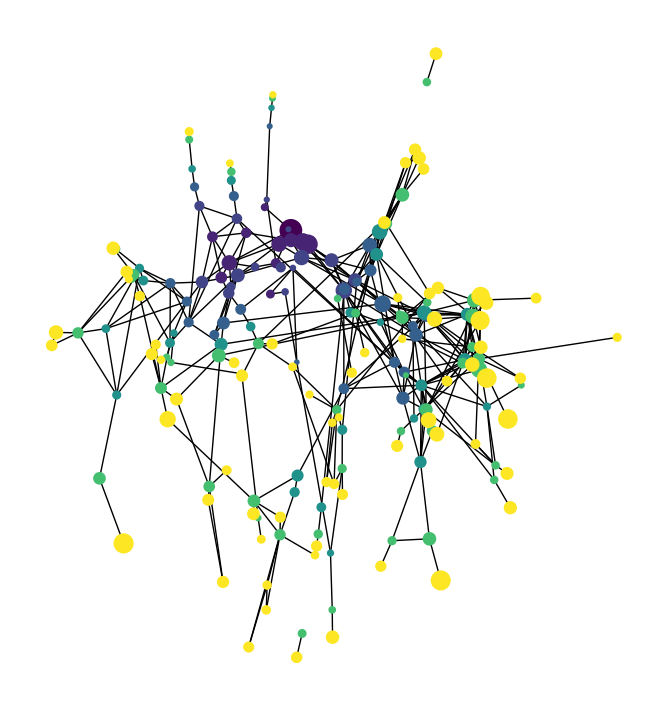

In [56]:
sc.pl.paga(adata, solid_edges='predicted_edges', **params, save='_prediction')

For comparison, the graph of Wagner et al.. Note that the latter is the union of the tresholded graph and a tree fit.

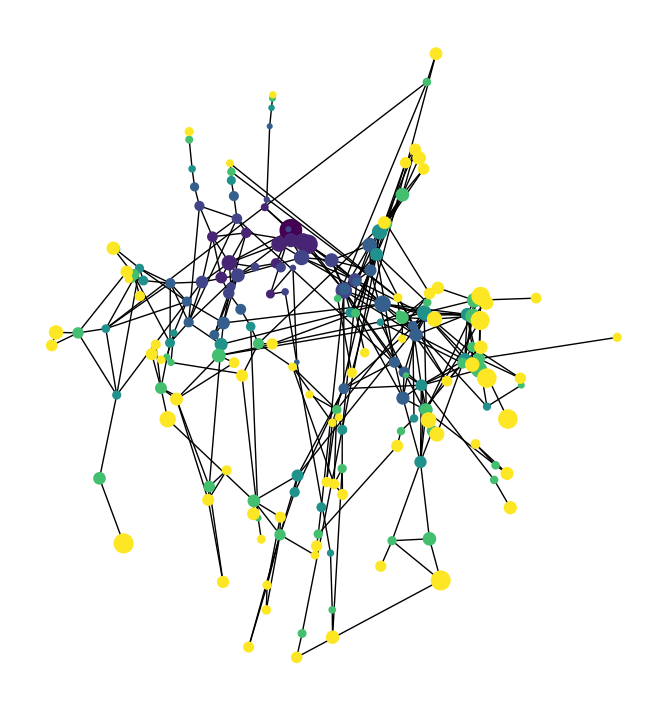

In [57]:
sc.pl.paga(adata, solid_edges='wagner18', **params)

And now the differences.

saving figure to file ./figures/paga_false_negatives.pdf


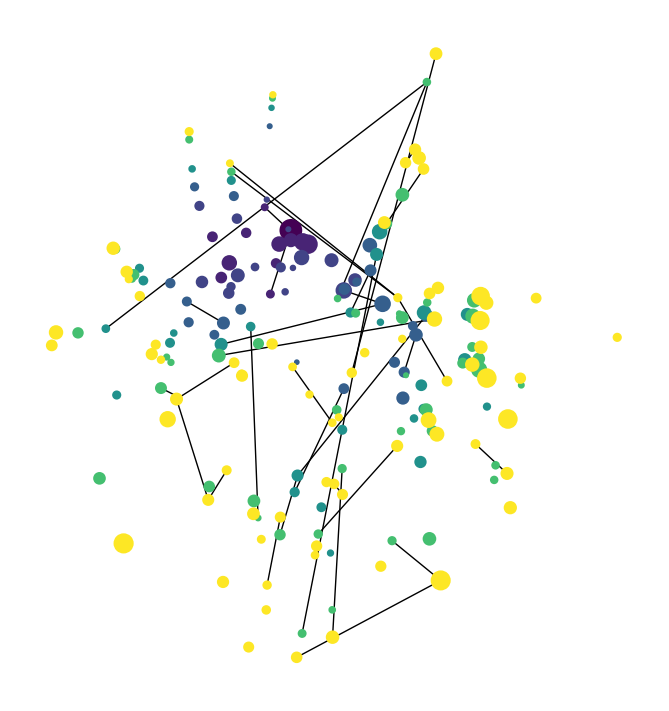

saving figure to file ./figures/paga_false_positives.pdf


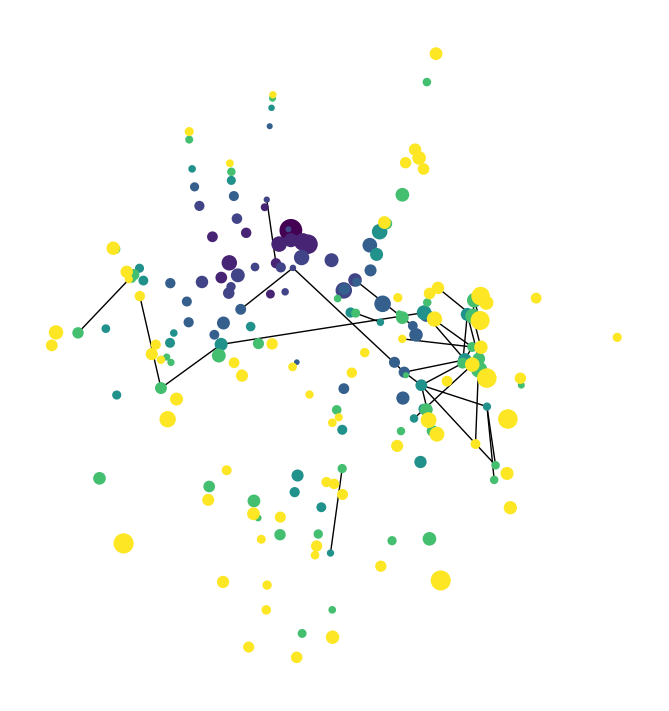

In [58]:
sc.pl.paga(adata, solid_edges='false_negatives', **params, save='_false_negatives')
sc.pl.paga(adata, solid_edges='false_positives', **params, save='_false_positives')

Finally, let us check how drawing the graph with a tree layout at this threshold would look like.

Restricting graph to largest connected component by dropping categories
['18hpf-lens placode', '18hpf-macrophage', '18hpf-macrophage - ly75', '24hpf-leukocyte', '24hpf-erythroid', '24hpf-macrophage', '24hpf-lens', '24hpf-differentiating neurons - sst1.1', '24hpf-pharyngeal arch - lbx1a']
saving figure to file ./figures/paga_tree.pdf


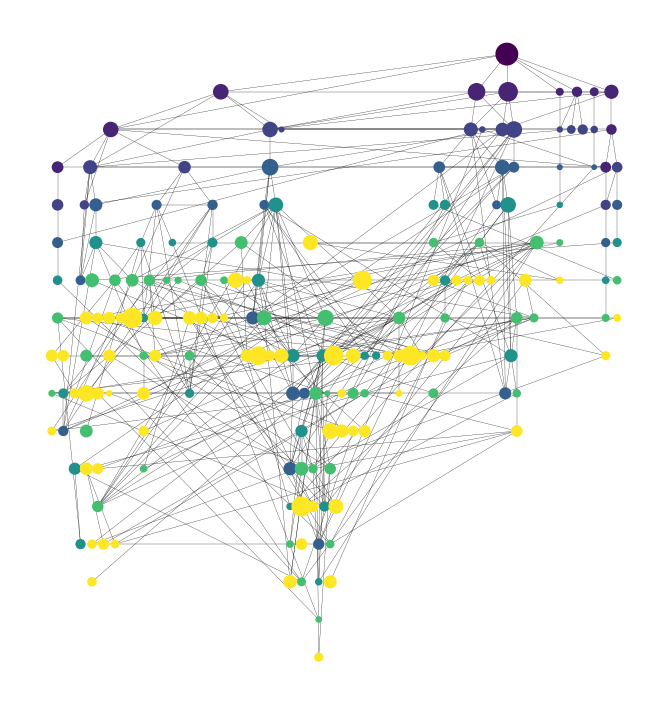

In [64]:
sc.pl.paga(adata, colors=clusters_time.astype(int), layout='rt', single_component=True,
           labels=labels, threshold=0.03, frameon=False,
           fontsize=2, text_kwds=dict(rotation=30),
           node_size_scale=0.1, max_edge_width=0.1, colorbar=False, add_pos=False, save='_tree')

In [65]:
adata.write(results_file)

## Reproduce the result of Wagner et al.

Also check what happens if we use the measure of Wagner et al.

In [50]:
from scanpy.tools.paga import PAGA

In [72]:
paga = PAGA(adata, 'clusters')

In [73]:
paga.compute_connectivities_coarse()

In [74]:
row_sums = paga.connectivities_coarse.sum(axis=1).A1  # number of outgoing edges

In [75]:
jaccard = paga.connectivities_coarse.copy()  # initializing
for i in range(paga.connectivities_coarse.shape[0]):
    for j in range(i+1, paga.connectivities_coarse.shape[1]):
        if paga.connectivities_coarse[i, j] > 0:
            jaccard[i, j] = paga.connectivities_coarse[i, j] / (row_sums[i] + row_sums[j])
            jaccard[j, i] = jaccard[i, j] 

Threshold at 0.01.

In [76]:
jaccard.data[jaccard.data < 0.01] = 0
jaccard.data[jaccard.data >= 0.01] = 1

The difference here is due to the fact that the wagner18 adjacency contains a second graph in addition to the one obtained thresholding.

In [78]:
np.sum(np.abs(wagner18 - jaccard))

20.0

In [79]:
false_negatives = wagner18 - jaccard  # additional edges of wagner18
false_negatives.data[false_negatives.data < 0] = 0
false_negatives.eliminate_zeros()

false_positives = jaccard - wagner18  # additional edges of PAGA
false_positives.data[false_positives.data < 0] = 0
false_positives.eliminate_zeros()

print('wagner18 edges:', wagner18.nnz)
print('sensitivity (detected edges):', (wagner18.nnz - false_negatives.nnz) / wagner18.nnz)
print('recall (correct detections):',  (jaccard.nnz - false_positives.nnz) / jaccard.nnz)

adata.uns['paga']['predicted_edges'] = wagner18
adata.uns['paga']['false_negatives'] = false_negatives
adata.uns['paga']['false_positives'] = false_positives

wagner18 edges: 752
sensitivity (detected edges): 0.973404255319149
recall (correct detections): 1.0


We're almost there. We just missed 10 edges.

Graph has more than a single connected component. To restrict to this component, pass `single_component=True`.
saving figure to file ./figures/paga_discrepancy.pdf


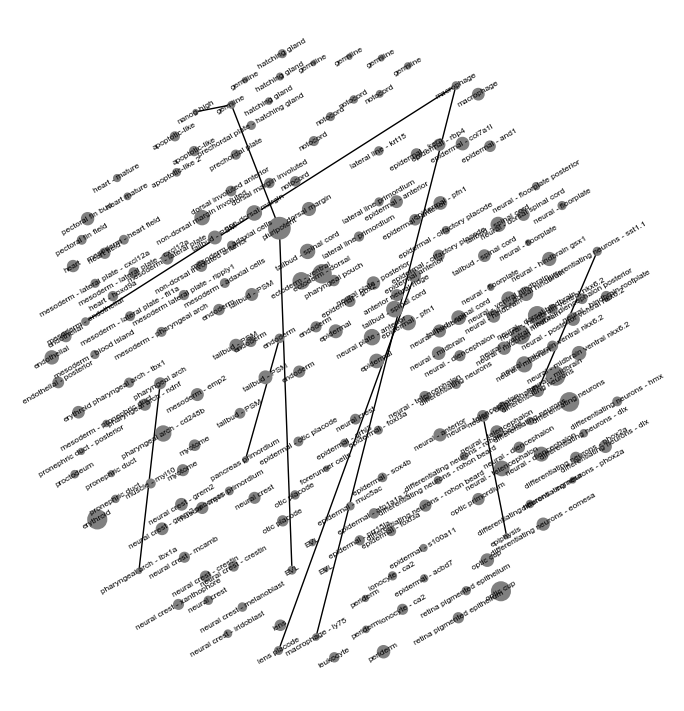

Graph has more than a single connected component. To restrict to this component, pass `single_component=True`.


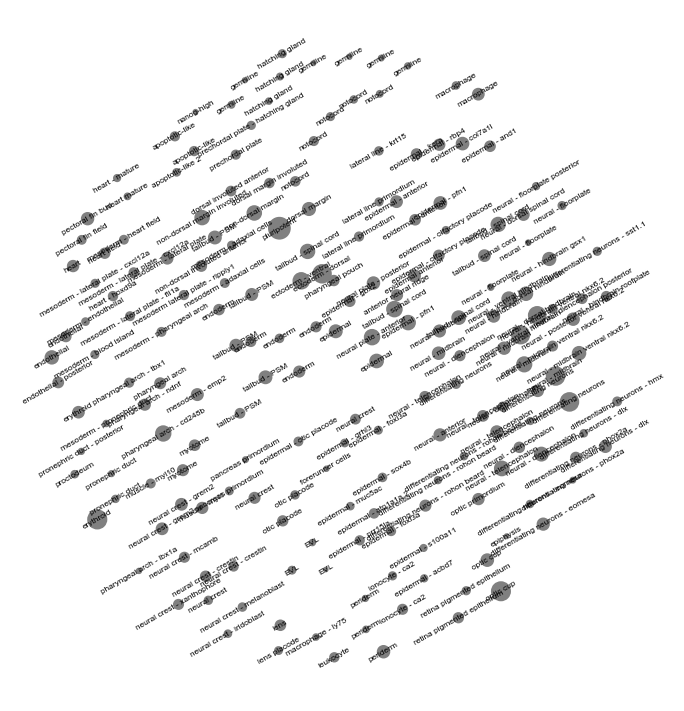

In [81]:
sc.pl.paga(adata, solid_edges='false_negatives', **params, save='_discrepancy')
sc.pl.paga(adata, solid_edges='false_positives', **params)

## Collapsing the AnnData object

In [45]:
adata = sc.read(results_file)

In [46]:
def read_counts():
    adata_counts = sc.read('./data/CountsNorm.csv', cache=True).T
    # this is not yet in sparse format, as the data was in a dense csv file
    from scipy.sparse import csr_matrix
    adata_counts.X = csr_matrix(adata_counts.X)
    adata_counts.write('./write/zebrafish_sparse_counts.h5ad')
# read_counts() 

In [47]:
adata_counts = sc.read('./write/zebrafish_sparse_counts.h5ad')

Let's remove the outliers as at the top of this notebook.

In [48]:
cluster_indices = np.genfromtxt('./data/cell_cluster_indexes.txt', dtype=int)
clusters = pd.Categorical(cluster_indices)
clusters.categories = ['?'] + np.genfromtxt('./data/cluster_names.txt', dtype=str, delimiter=',').tolist()

In [49]:
adata_counts = adata_counts[clusters != '?']

We can now set the data matrix.

In [50]:
adata.X = adata_counts.X

In [51]:
adata = adata[:, :5]  # for demonstration purposes, speed up this
sc.pp.subsample(adata, 0.5)

In [52]:
def collapse(adata, key, threshold=0.01):
    from pandas.api.types import is_string_dtype, is_categorical 
    cats = adata.obs[key].cat.categories
    n_cats = len(cats)
    X = np.zeros((n_cats, adata.n_vars), dtype='float32')
    obs_keys = [k for k in adata.obs.columns if k != key]
    obs = pd.DataFrame(
        {k: np.zeros(
                n_cats,
                dtype=adata.obs[k].dtype if not is_categorical(adata.obs[k]) else object)
         for k in obs_keys })
    for icat, cat in enumerate(cats):
        subset = (cat == adata.obs[key]).values 
        X_subset = adata.X[subset]  # this takes quite a while, but it should be slower as csc
        X[icat] = X_subset.tocsc().mean(axis=0).A1  # should be a lot faster as csc
        for k in obs_keys:                                                                                                                                                                                           
            if is_string_dtype(adata.obs[k]) or is_categorical(adata.obs[k]):
                obs[k].iloc[icat] = (
                    ','.join(adata.obs[k].iloc[subset].cat\
                             .remove_unused_categories().cat.categories))
            else:
                obs[k].iloc[icat] = adata.obs[k].iloc[subset].mean() 
    connectivities = adata.uns['paga']['confidence'].copy()
    connectivities[connectivities < threshold] = 0
    connectivities.eliminate_zeros()
    uns = {'neighbors': {'connectivities': connectivities}} 
    adata_collapsed = sc.AnnData(X, obs=obs, uns=uns)
    adata_collapsed.obs_names = cats
    adata_collapsed.obsm['X_draw_graph_fr'] = adata.uns['paga']['pos']
    adata_collapsed.uns['draw_graph'] = {'params': {'layout': 'fr'}}
    return adata_collapsed

In [53]:
adata_collapsed = collapse(adata, 'clusters', threshold=0.02)

In [54]:
adata_collapsed

AnnData object with n_obs × n_vars = 195 × 5 
    obs: 'clusters_coarse', 'clusters_coarse_time', 'clusters_time', 'time'
    uns: 'neighbors', 'draw_graph'
    obsm: 'X_draw_graph_fr'

In [55]:
adata_collapsed.obs.head()

clusters_coarse  \
04hpf-pluripotent                                  pluripotent   
06hpf-non-dorsal margin                      non-dorsal margin   
06hpf-non-dorsal margin involuted  non-dorsal margin involuted   
06hpf-ectoderm - ventral                              ectoderm   
06hpf-dorsal margin involuted          dorsal margin involuted   

                                                clusters_coarse_time  \
04hpf-pluripotent                                  04hpf-pluripotent   
06hpf-non-dorsal margin                      06hpf-non-dorsal margin   
06hpf-non-dorsal margin involuted  06hpf-non-dorsal margin involuted   
06hpf-ectoderm - ventral                              06hpf-ectoderm   
06hpf-dorsal margin involuted          06hpf-dorsal margin involuted   

                                  clusters_time  time  
04hpf-pluripotent                            04   4.0  
06hpf-non-dorsal margin                      06   6.0  
06hpf-non-dorsal margin involuted            06   6.0  
06hpf-ectoderm - ventral                     06   6.0  
06hpf-dorsal margin involuted                06   6.0

... storing 'clusters_coarse' as categorical
... storing 'clusters_coarse_time' as categorical
... storing 'clusters_time' as categorical


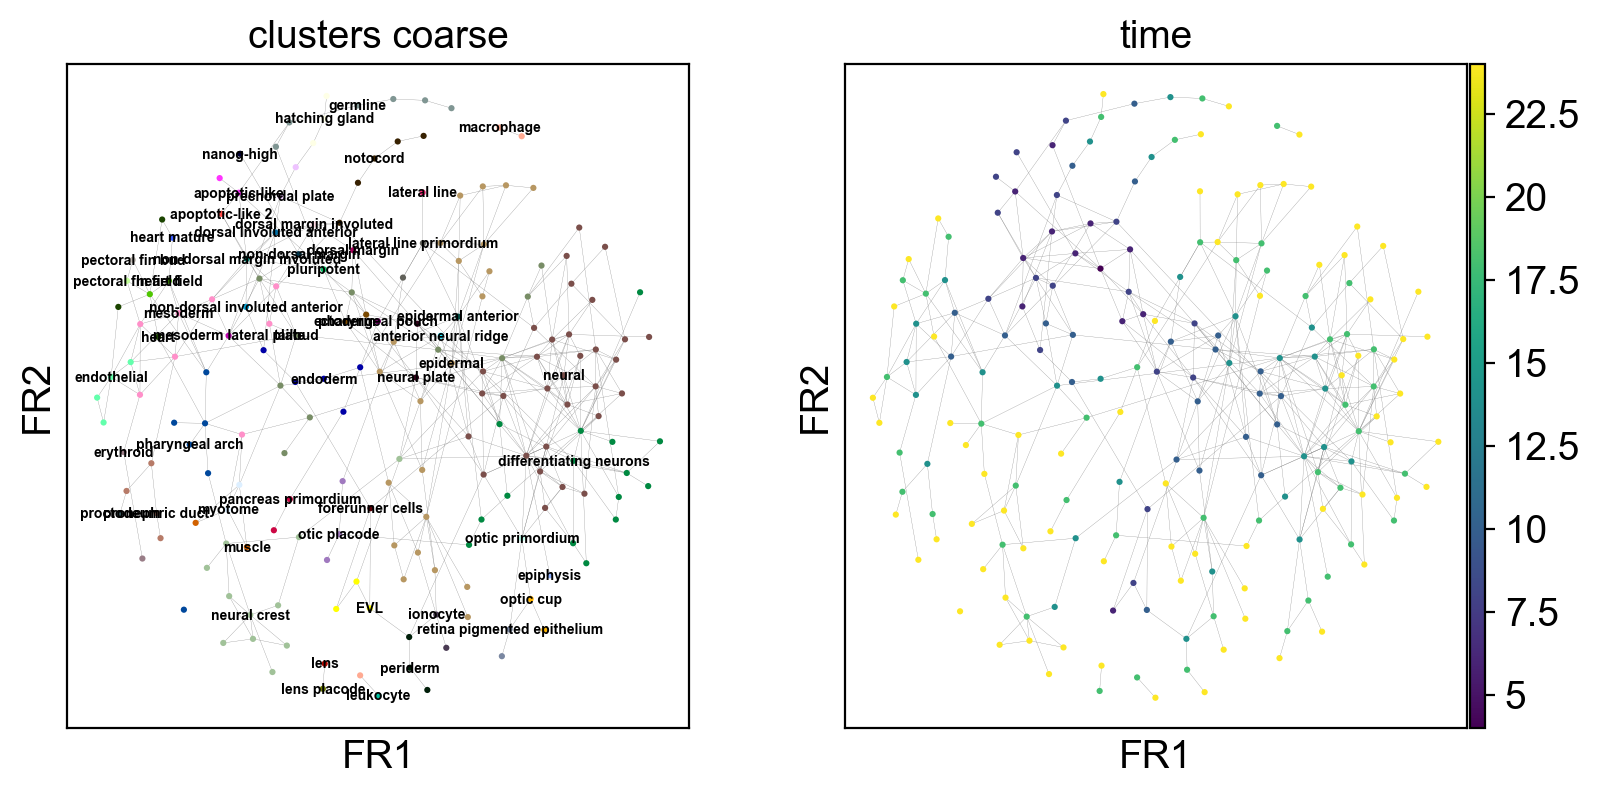

In [56]:
sc.pl.draw_graph(adata_collapsed, color=['clusters_coarse', 'time'], legend_loc='on data', legend_fontsize=5, size=20, edges=True)

This is equivalent the paga visualization above.

In [57]:
sc.export_to.spring_project(
    adata_collapsed,
    '../../../1512_scanpy/scanpy_usage/171111_SPRING_export/spring_zebrafish1',
    use_genes=adata_collapsed.var_names[:5])

more than 103 colors would be required, initializing as 'grey'


Read in SPRING coordinates.

In [58]:
X_fa = np.loadtxt('./write/coordinates.txt', delimiter=',')[:, 1:]

In [59]:
adata_collapsed.obsm['X_draw_graph_fa'] = X_fa

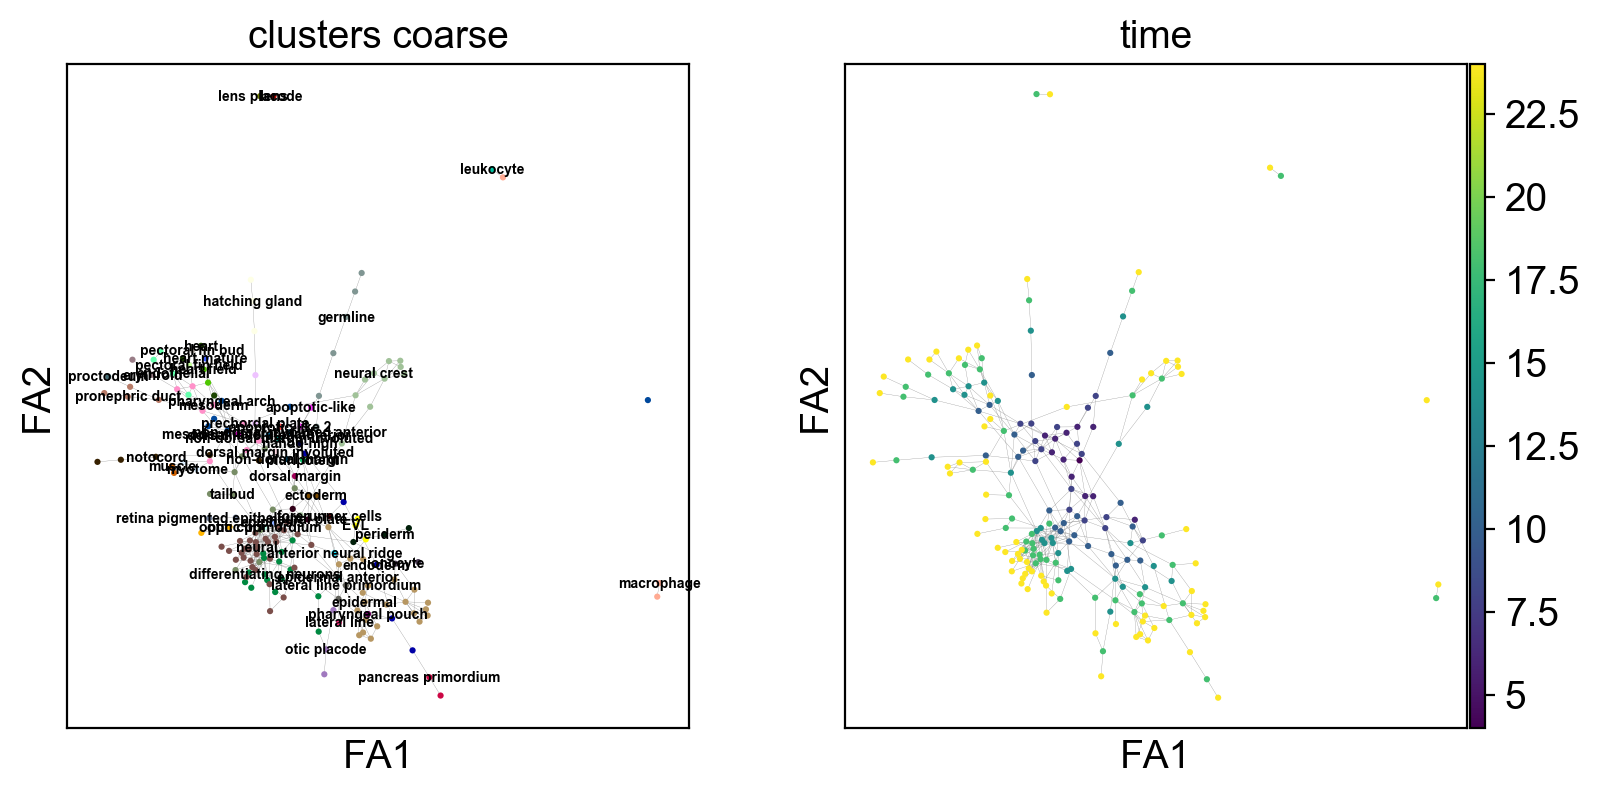

In [60]:
sc.pl.draw_graph(adata_collapsed, color=['clusters_coarse', 'time'], legend_loc='on data', legend_fontsize=5, size=20, edges=True, layout='fa')